In [54]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [57]:
import pandas as pd
import numpy as np
from empiricaldist import Pmf
from scipy.stats import poisson
from scipy.stats import binom
from utils import normalize

In [58]:
import pandas as pd
import numpy as np
from empiricaldist import Pmf
from scipy.stats import poisson
from scipy.stats import binom
from utils import normalize

In [72]:
ss = np.linspace(0, 350, 101)   # n ~ P(s)
ns = np.arange(0, 350)
prior_s = Pmf(1, ss)

def make_joint(prior_s, ns):
    ss = prior_s.qs
    S, N = np.meshgrid(ss, ns) #(350, 101) / meshgrid는 뒤쪽에 오는 녀석의 차원먼저 읽힌다. 뒤에서 생성되고 그 앞으로 하나씩 추가되는 거라고 생각하면 된다.
    ps = poisson(S).pmf(N) * prior_s.ps # (350, 101) = (350, 101) * (101,) / 이때도 마찬가지로, 먼저 (101)이 만들어지고, 350이 만들어지는 것이므로 101-101이 매칭되고, 350이 추가되었다고 보면 된다. 따라서 새로운 변수에 대해 구현할 때도 P(s) * P(n|s)라면, priro_s.ps를 쓰고 그 왼쪽에 poisson(S).pmf(N)을 쓰면 된다.
    # 해석: (s, n)의 prior probability. 이때, s와 n이 동시에 발생할 확률은 P(s, n) = P(s) * P(n|s)가 된다.
    # 오해: 모든 경우의 베이즈 업데이트에 대한 테이블. 단, 정규화 하지 않음
    joint = pd.DataFrame(ps, index=ns, columns=ss) #(s, n)의 prior probability
    joint.index.name = 'n'
    joint.columns.name = 's'
    return joint

joint = make_joint(prior_s, ns)
joint.head()

s,0.0,3.5,7.0,10.5,14.0,17.5,21.0,24.5,28.0,31.5,...,318.5,322.0,325.5,329.0,332.5,336.0,339.5,343.0,346.5,350.0
n,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.030197,0.000912,0.000028,8.315287e-07,2.510999e-08,7.582560e-10,2.289735e-11,6.914400e-13,2.087968e-14,...,4.755624e-139,1.436074e-140,4.336568e-142,1.309530e-143,3.954438e-145,1.194137e-146,3.605981e-148,1.088912e-149,3.288229e-151,9.929590e-153
1,0.0,0.105691,0.006383,0.000289,1.164140e-05,4.394249e-07,1.592338e-08,5.609850e-10,1.936032e-11,6.577099e-13,...,1.514666e-136,4.624158e-138,1.411553e-139,4.308354e-141,1.314851e-142,4.012300e-144,1.224230e-145,3.734968e-147,1.139371e-148,3.475357e-150
2,0.0,0.184959,0.022341,0.001518,8.148981e-05,3.844967e-06,1.671955e-07,6.872067e-09,2.710445e-10,1.035893e-11,...,2.412106e-134,7.444895e-136,2.297302e-137,7.087242e-139,2.185939e-140,6.740663e-142,2.078131e-143,6.405469e-145,1.973961e-146,6.081874e-148
3,0.0,0.215785,0.052129,0.005313,3.802858e-04,2.242898e-05,1.170368e-06,5.612188e-08,2.529749e-09,1.087688e-10,...,2.560853e-132,7.990854e-134,2.492573e-135,7.772342e-137,2.422749e-138,7.549543e-140,2.351752e-141,7.323587e-143,2.279925e-144,7.095520e-146
4,0.0,0.188812,0.091226,0.013946,1.331000e-03,9.812677e-05,6.144433e-06,3.437465e-07,1.770824e-08,8.565541e-10,...,2.039079e-130,6.432637e-132,2.028331e-133,6.392751e-135,2.013910e-136,6.341616e-138,1.996049e-139,6.279975e-141,1.974985e-142,6.208580e-144


In [60]:
def update(joint, c, phi = 0.1):
    ns = joint.index
    likelihood = binom(ns, phi).pmf(c) #L(θ=(n, phi)|x = c): lik of the data x regardless of s
    posterior = joint.multiply(likelihood, axis=0) #(s, n)의 post probability
    # joint: (350, 101), likelihood: (350,) 이므로 likelihood를 T한 후 우변에 곱해주어야 한다. 그러나 series를 T해도 동일한 shape이므로 joint를 T 해준 후 원복해줘야 한다.
    # 즉, (likelihood * joint.T).T와 같다
    normalize(posterior)
    return posterior
#Question: 만약 p도 알려지지 않았다면 어떻게 추론해야할까?

In [74]:
c1 = 10
phi = 0.1
posterior = update(joint, c1, phi)
posterior.head()

s,0.0,3.5,7.0,10.5,14.0,17.5,21.0,24.5,28.0,31.5,...,318.5,322.0,325.5,329.0,332.5,336.0,339.5,343.0,346.5,350.0
n,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


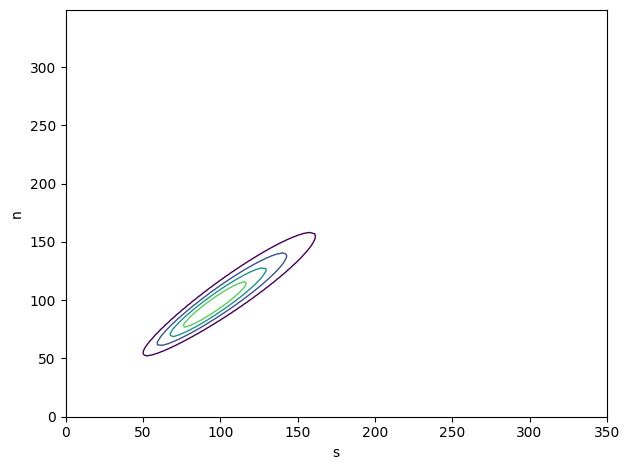

In [75]:
from utils import plot_contour

plot_contour(posterior)

109.99983355767431

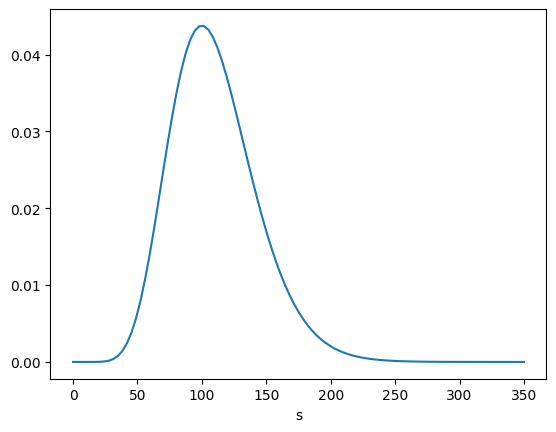

In [84]:
from utils import marginal

posterior_s = marginal(posterior, 0)
posterior_s.plot()
posterior_s.mean()

In [85]:
posterior

s,0.0,3.5,7.0,10.5,14.0,17.5,21.0,24.5,28.0,31.5,...,318.5,322.0,325.5,329.0,332.5,336.0,339.5,343.0,346.5,350.0
n,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.0,0.0,0.0,0.0,0.0,6.925323e-314,4.344494e-288,1.638894e-266,5.032016e-248,6.750432e-232,...,6.957125e-10,9.118412e-10,1.147375e-09,1.387289e-09,1.613134e-09,1.805392e-09,1.946317e-09,2.022697e-09,2.027898e-09,1.962788e-09
346,0.0,0.0,0.0,0.0,0.0,3.246245e-315,2.443778e-289,1.075524e-267,3.774012e-249,5.695677e-233,...,5.935298e-10,7.864631e-10,1.000368e-09,1.222548e-09,1.436698e-09,1.624853e-09,1.769932e-09,1.858353e-09,1.882143e-09,1.840113e-09
347,0.0,0.0,0.0,0.0,0.0,1.517162e-316,1.370546e-290,7.037185e-269,2.822110e-250,4.791467e-234,...,5.048525e-10,6.763116e-10,8.696073e-10,1.074174e-09,1.275762e-09,1.458028e-09,1.604756e-09,1.702295e-09,1.741680e-09,1.719987e-09
